In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%cd '/Users/rewatsachdeva/Desktop/assesment/Arya_DataScientist_Assignment'

train_benef=pd.read_csv('Medicare-Fraud-Detection-DS/train_beneficiarydata.csv')
train_labels=pd.read_csv('Medicare-Fraud-Detection-DS/train.csv')
train_ip = pd.read_csv('Medicare-Fraud-Detection-DS/train_inpatientdata.csv')
train_op=pd.read_csv('Medicare-Fraud-Detection-DS/train_outpatientdata.csv')

columns_to_join=train_op.columns.to_list()
train_df=pd.merge(train_op,train_ip,left_on=columns_to_join,right_on=columns_to_join,how='outer')
train_df=pd.merge(train_df,train_benef,on='BeneID',how='left')
data=pd.merge(train_df,train_labels,on='Provider',how='left')

/Users/rewatsachdeva/Desktop/assesment/Arya_DataScientist_Assignment


In [3]:
def creat_feat(df):
    df['AdmissionDt']=pd.to_datetime(df['AdmissionDt'])
    df['DischargeDt']=pd.to_datetime(df['DischargeDt'])
    df['StayDuration']=df['DischargeDt']-df['AdmissionDt']
    df['StayDuration']=df['StayDuration'].dt.days

    df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'])
    df['ClaimEndDt'] = pd.to_datetime(df['ClaimEndDt'])
    df['ClaimDuration'] = (df['ClaimEndDt'] - df['ClaimStartDt']).dt.days

    df['DOD'].fillna('2009-12-01', inplace=True)
    df['DOB']=pd.to_datetime(df['DOB'])
    df['DOD']=pd.to_datetime(df['DOD'])
    # df['DOD'].replace(0,max(df['DOD']), inplace=True)
    df['Age']=df['DOD']-df['DOB']
    df['Age']=df['Age'].dt.days/365

    # drop_cols=['AdmissionDt','DischargeDt','ClaimStartDt','ClaimEndDt','DOD','DOB']
    # df.drop(drop_cols,axis=1,inplace=True)

creat_feat(data)

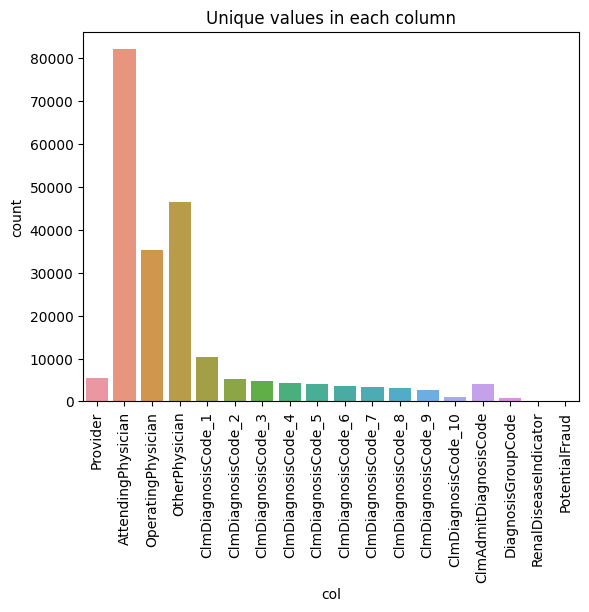

In [4]:
cnts={}
for col in data.columns:
    if data[col].dtype=='object' and col not in ['ClaimID','BeneID']:
        cnts[col]=data[col].nunique()

cnt=pd.DataFrame(cnts.items(),columns=['col','count'])

sns.barplot(x='col',y='count',data=cnt)
plt.title('Unique values in each column')
plt.xticks(rotation=90)
plt.show()

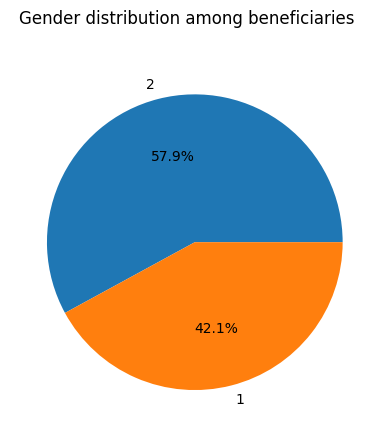

In [34]:
vals=data['Gender'].value_counts()
plt.suptitle('Gender distribution among beneficiaries')
plt.pie(vals.values,labels=vals.keys(),autopct='%1.1f%%')
plt.show()

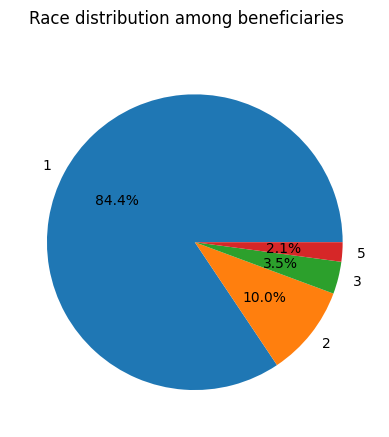

In [5]:
vals=data['Race'].value_counts()
plt.suptitle('Race distribution among beneficiaries')
plt.pie(vals.values,labels=vals.keys(),autopct='%1.1f%%')
plt.show()

In [22]:
data=pd.merge(data,train_labels,on='Provider',how='left')
data['PotentialFraud'].value_counts()

PotentialFraud
No     345415
Yes    212796
Name: count, dtype: int64

In [6]:
from sklearn.utils import resample

df_majority = data[data['PotentialFraud'] == 'No']
df_minority = data[data['PotentialFraud'] == 'Yes']


df_majority_downsampled = resample(df_majority, 
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)


data = pd.concat([df_minority, df_majority_downsampled])

print(data['PotentialFraud'].value_counts()) 

PotentialFraud
Yes    212796
No     212796
Name: count, dtype: int64


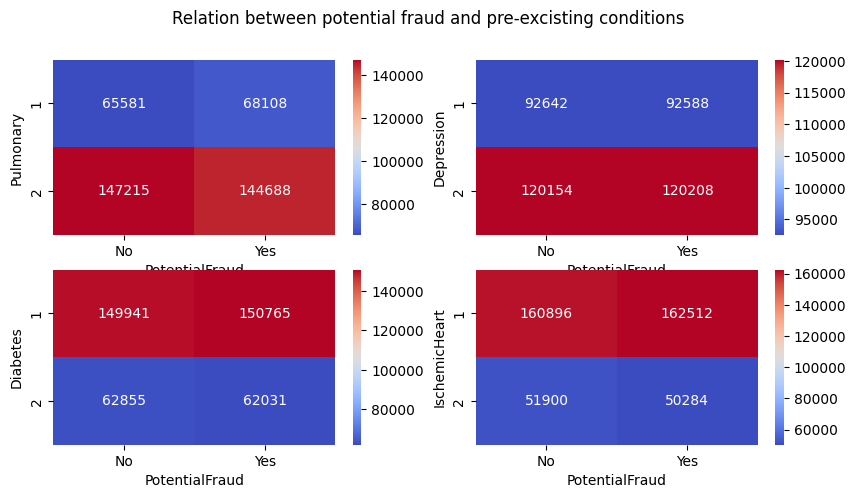

In [35]:
fig,axs = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Relation between potential fraud and pre-excisting conditions')
crosstab = pd.crosstab(index=data['ChronicCond_ObstrPulmonary'], columns=[data['PotentialFraud']],rownames=['Pulmonary'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[0][0]) 

crosstab = pd.crosstab(index=data['ChronicCond_Depression'], columns=[data['PotentialFraud']],rownames=['Depression'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[0][1]) 

crosstab = pd.crosstab(index=data['ChronicCond_Diabetes'], columns=[data['PotentialFraud']],rownames=['Diabetes'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[1][0]) 

crosstab = pd.crosstab(index=data['ChronicCond_IschemicHeart'], columns=[data['PotentialFraud']],rownames=['IschemicHeart'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[1][1])
plt.show() 

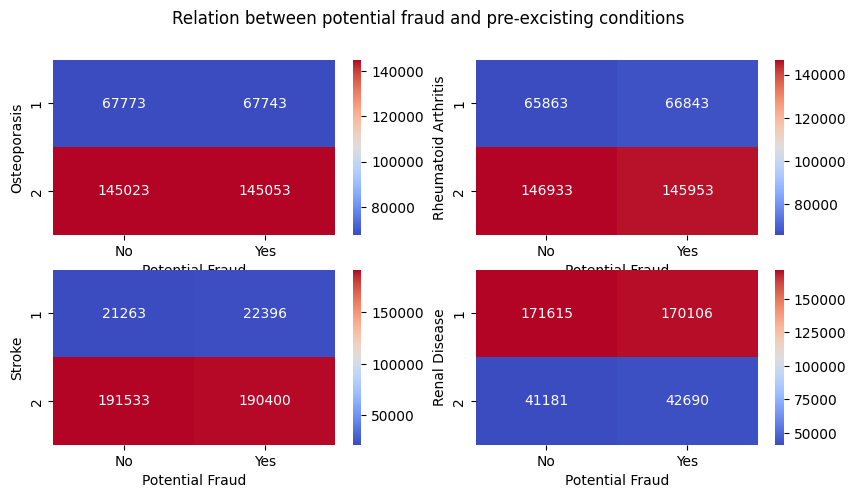

In [36]:
fig,axs = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Relation between potential fraud and pre-excisting conditions')
crosstab = pd.crosstab(index=data['ChronicCond_Osteoporasis'],columns=[data['PotentialFraud']],
                        rownames=['Osteoporasis'],colnames=['Potential Fraud'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[0][0]) 

crosstab = pd.crosstab(index=data['ChronicCond_rheumatoidarthritis'],columns=[data['PotentialFraud']],
                        rownames= ['Rheumatoid Arthritis'],colnames=['Potential Fraud'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[0][1]) 

crosstab = pd.crosstab(index=data['ChronicCond_stroke'], columns=[data['PotentialFraud']],
                        rownames= ['Stroke'],colnames=['Potential Fraud'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[1][0])

data['RenalDiseaseIndicator'].replace({'Y':2,'0':1},inplace=True)
crosstab = pd.crosstab(index=data['RenalDiseaseIndicator'], columns=[data['PotentialFraud']],
                        rownames= ['Renal Disease'],colnames=['Potential Fraud'])
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d',ax=axs[1][1])
plt.show()

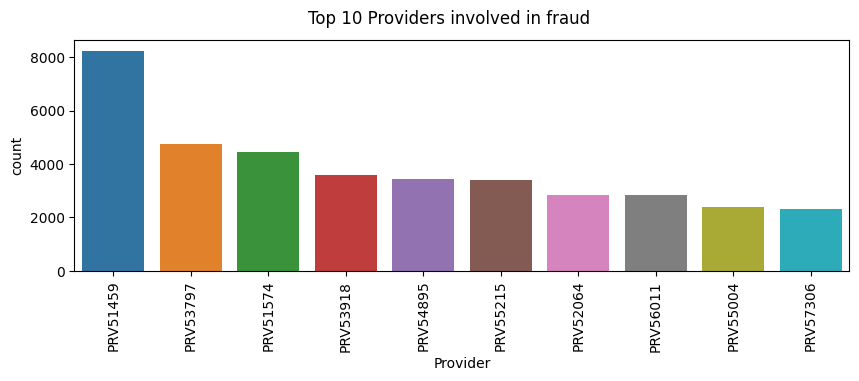

In [9]:
fig,ax=plt.subplots(1,1,figsize=(10,3))
fig.suptitle('Top 10 Providers involved in fraud')
df=data.groupby('PotentialFraud')['Provider'].value_counts().sort_values(ascending=False)['Yes'].reset_index()[:10]
sns.barplot(x='Provider',y='count',data=df)
plt.xticks(rotation=90)
plt.show()

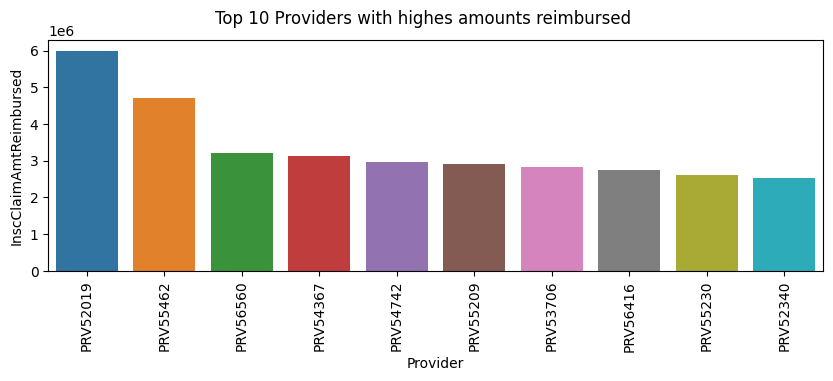

In [8]:
fig,ax=plt.subplots(1,1,figsize=(10,3))
fig.suptitle('Top 10 Providers with highest amounts reimbursed')
df=data.groupby('Provider')['InscClaimAmtReimbursed'].sum().sort_values(ascending=False).reset_index()[:10]
sns.barplot(x='Provider',y='InscClaimAmtReimbursed',data=df)
plt.xticks(rotation=90)
plt.show()

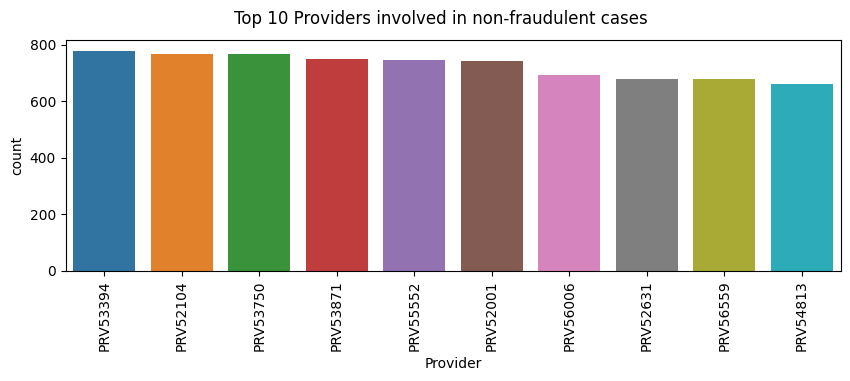

In [17]:
fig,ax=plt.subplots(1,1,figsize=(10,3))
fig.suptitle('Top 10 Providers involved in non-fraudulent cases')
df=data.groupby('PotentialFraud')['Provider'].value_counts().sort_values(ascending=False)['No'].reset_index()[:10]
sns.barplot(x='Provider',y='count',data=df)
plt.xticks(rotation=90)
plt.show()

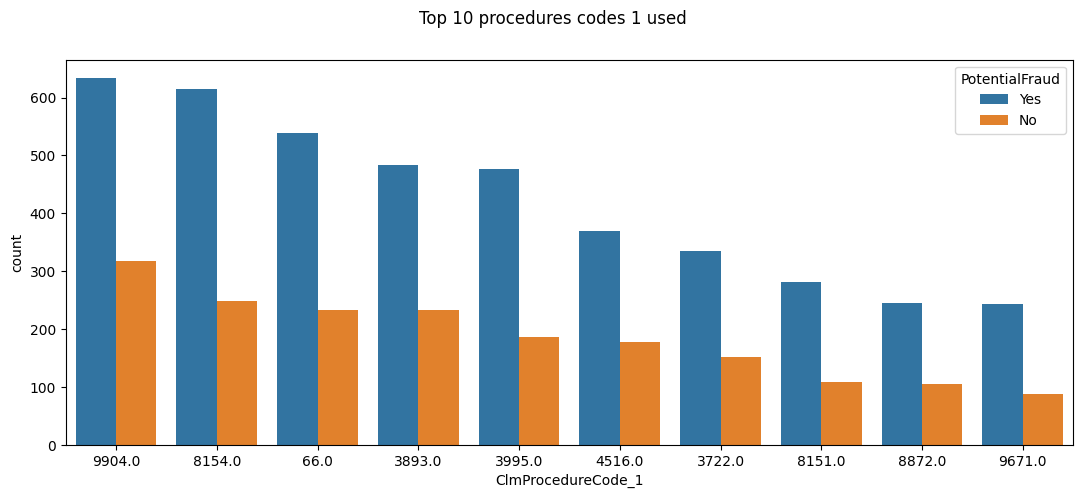

In [15]:
fig,ax=plt.subplots(1,1,figsize=(13,5))
fig.suptitle('Top 10 procedures codes 1 used')
sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=data,
              order=data['ClmProcedureCode_1'].value_counts().iloc[:10].index)
plt.show()

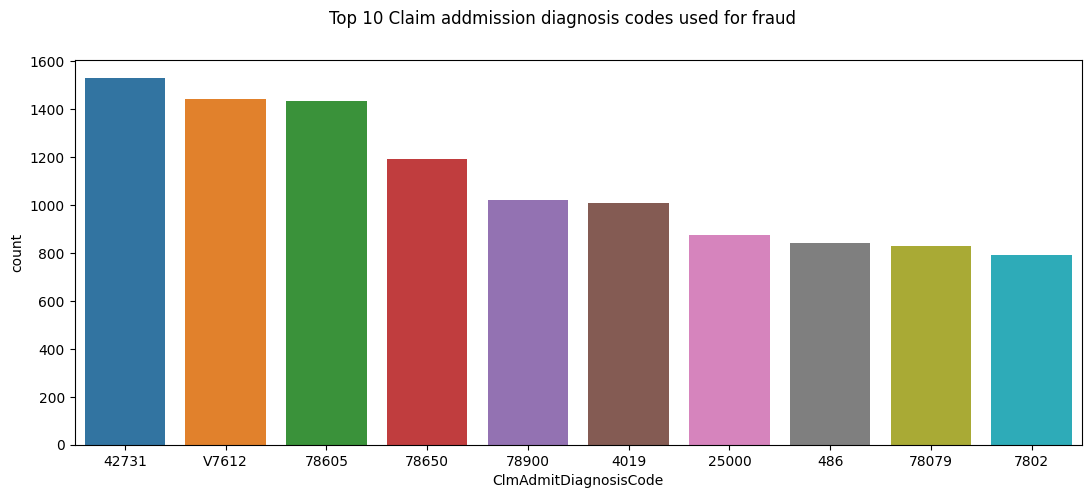

In [10]:
fig,ax=plt.subplots(1,1,figsize=(13,5))
fig.suptitle('Top 10 Claim addmission diagnosis codes used for fraud')
df=data.groupby('PotentialFraud')['ClmAdmitDiagnosisCode'].value_counts().sort_values(ascending=False)['Yes'].reset_index()[:10]
sns.barplot(x='ClmAdmitDiagnosisCode',y='count',data=df)
plt.show()

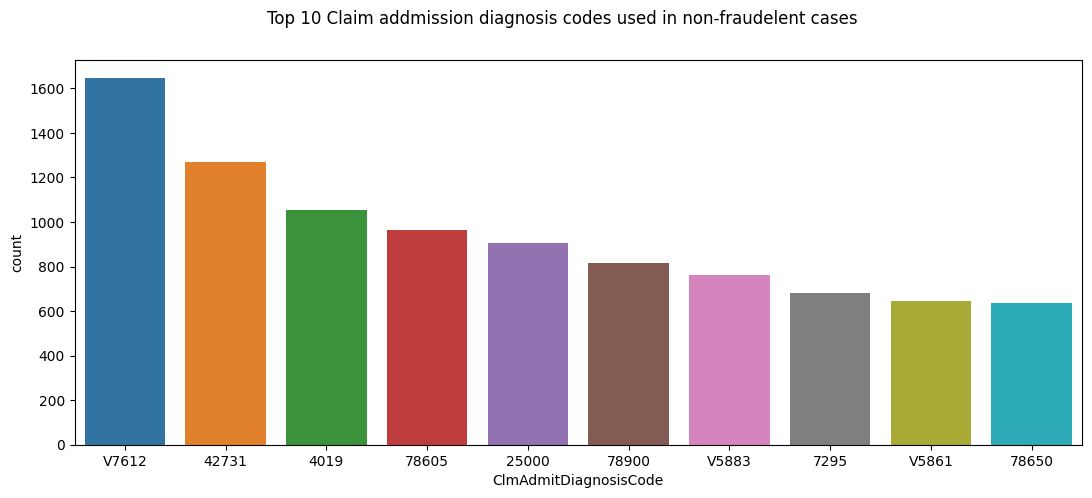

In [22]:
fig,ax=plt.subplots(1,1,figsize=(13,5))
fig.suptitle('Top 10 Claim addmission diagnosis codes used in non-fraudelent cases')
df=data.groupby('PotentialFraud')['ClmAdmitDiagnosisCode'].value_counts().sort_values(ascending=False)['No'].reset_index()[:10]
sns.barplot(x='ClmAdmitDiagnosisCode',y='count',data=df)
plt.show()

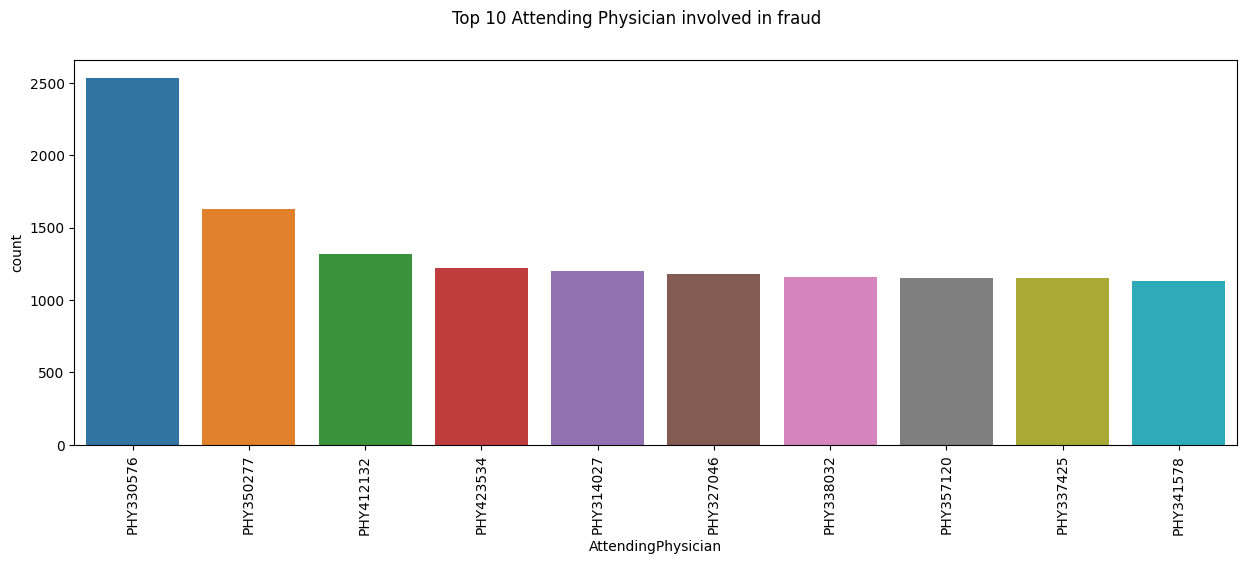

In [27]:
fig,axs=plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Top 10 Attending Physician involved in fraud')
df=data.groupby('PotentialFraud')['AttendingPhysician'].value_counts().sort_values(ascending=False)['Yes'].reset_index()[:10]
sns.barplot(x='AttendingPhysician',y='count',data=df)
plt.xticks(rotation=90)
plt.show()

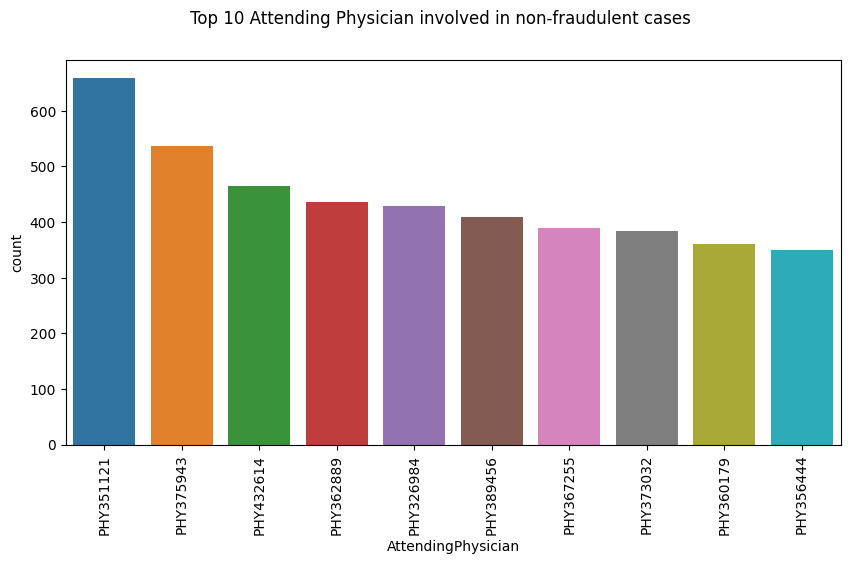

In [29]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
fig.suptitle('Top 10 Attending Physician involved in non-fraudulent cases')
df=data.groupby('PotentialFraud')['AttendingPhysician'].value_counts().sort_values(ascending=False)['No'].reset_index()[:10]
sns.barplot(x='AttendingPhysician',y='count',data=df)
plt.xticks(rotation=90)
plt.show()

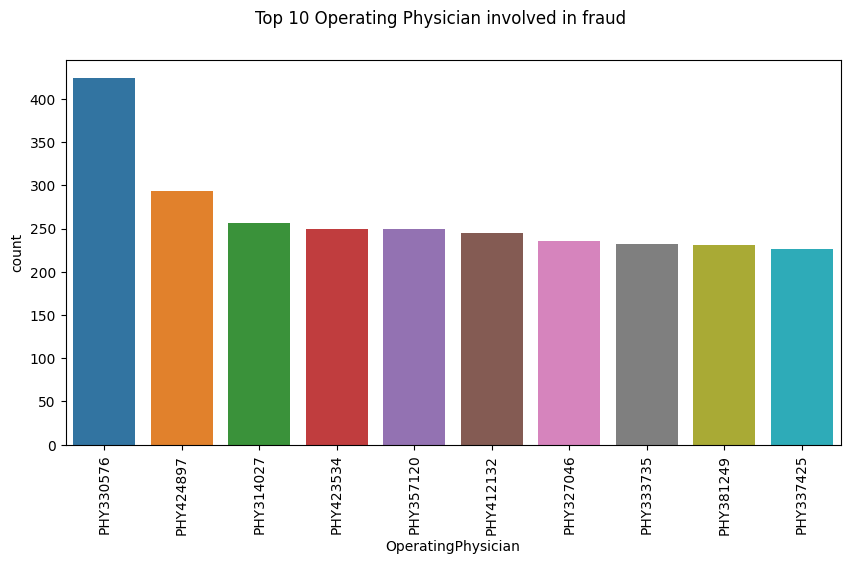

In [18]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
fig.suptitle('Top 10 Operating Physician involved in fraud')
df=data.groupby('PotentialFraud')['OperatingPhysician'].value_counts().sort_values(ascending=False)
d1=df['Yes'].reset_index()[:10]
sns.barplot(x='OperatingPhysician',y='count',data=d1)
plt.xticks(rotation=90)
plt.show()

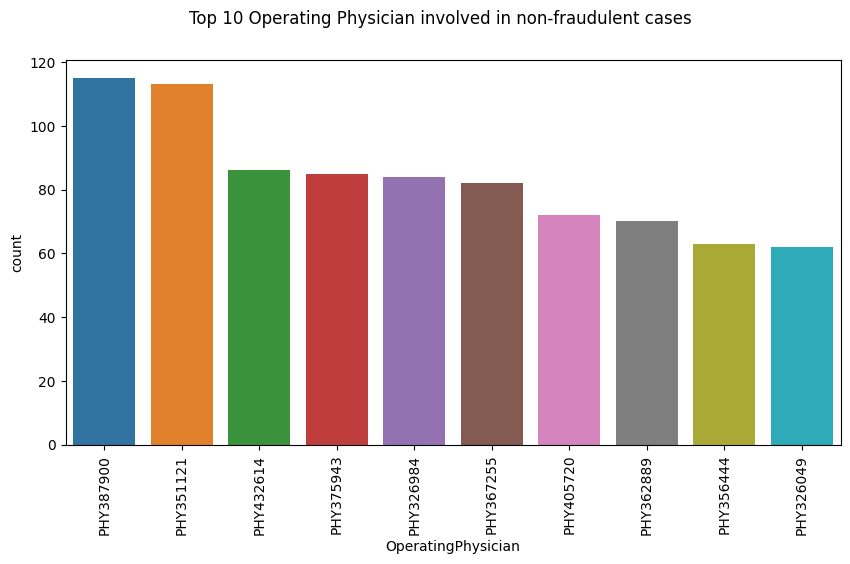

In [30]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
fig.suptitle('Top 10 Operating Physician involved in non-fraudulent cases')
df=data.groupby('PotentialFraud')['OperatingPhysician'].value_counts().sort_values(ascending=False)
d1=df['No'].reset_index()[:10]
sns.barplot(x='OperatingPhysician',y='count',data=d1)
plt.xticks(rotation=90)
plt.show()

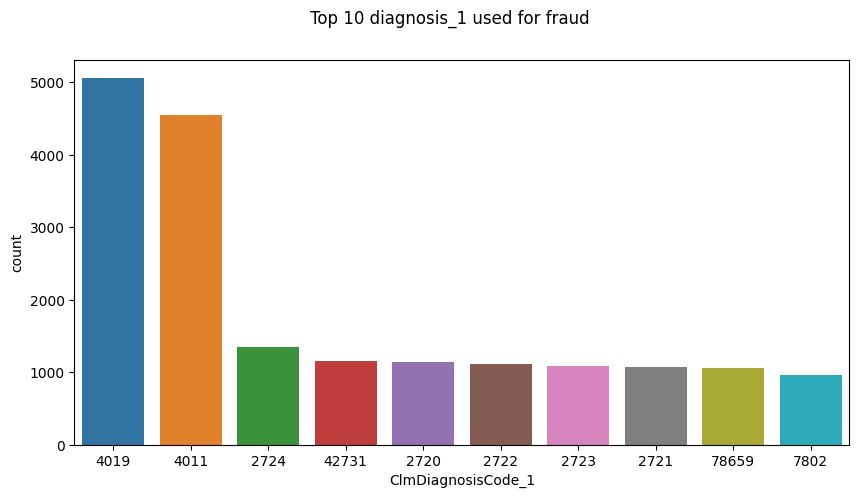

In [19]:
fig,ax=plt.subplots(figsize=(10,5))
fig.suptitle('Top 10 diagnosis_1 used for fraud')
df=data.groupby('PotentialFraud')['ClmDiagnosisCode_1'].value_counts().sort_values(ascending=False)['Yes'].reset_index()[:10]
# sns.countplot(x='ClmDiagnosisCode_1',hue='PotentialFraud',data=data,order=data['ClmDiagnosisCode_1'].value_counts().iloc[:10].index)
sns.barplot(x='ClmDiagnosisCode_1',y='count',data=df)
plt.show()

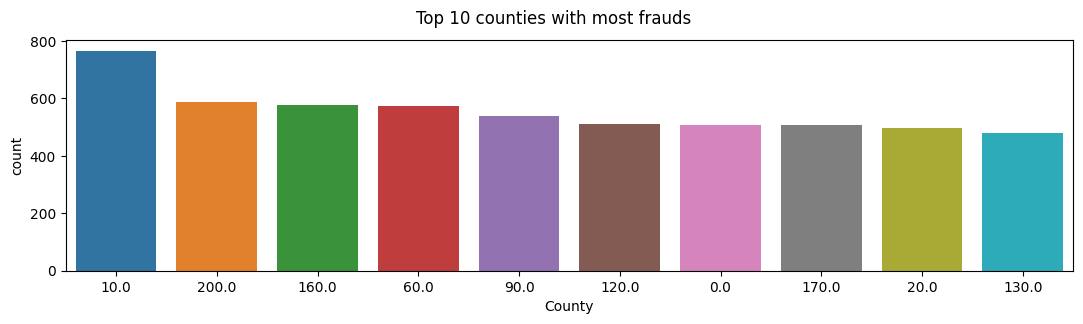

In [63]:
fig,ax=plt.subplots(1,1,figsize=(13,3))
df=data.groupby('PotentialFraud')['County'].value_counts().sort_values(ascending=False)['Yes'].reset_index()[:10]
fig.suptitle('Top 10 counties with most frauds')
sns.barplot(x='County',y='count',data=df,order=df['County'])
plt.show()


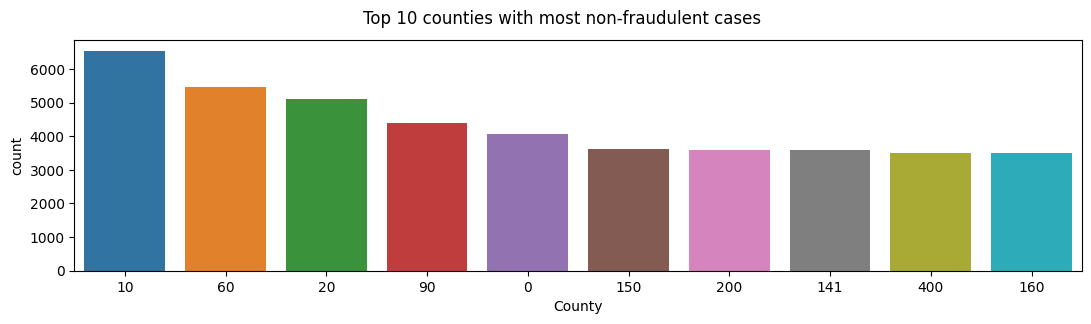

In [11]:
fig,ax=plt.subplots(1,1,figsize=(13,3))
df=data.groupby('PotentialFraud')['County'].value_counts().sort_values(ascending=False)['No'].reset_index()[:10]
fig.suptitle('Top 10 counties with most non-frauduelent cases')
sns.barplot(x='County',y='count',data=df,order=df['County'])
plt.show()

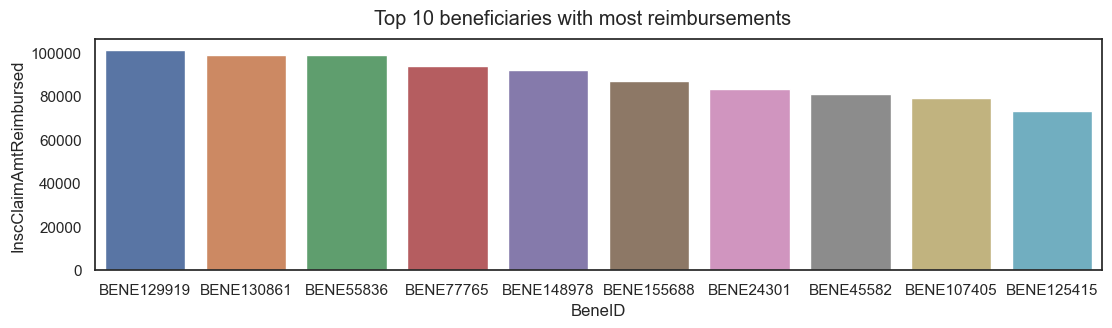

In [123]:
fig,ax=plt.subplots(1,1,figsize=(13,3))
df=data.groupby('BeneID')['InscClaimAmtReimbursed'].mean().sort_values(ascending=False).reset_index()[:10]
fig.suptitle('Top 10 beneficiaries with most reimbursements')
sns.barplot(x='BeneID',y='InscClaimAmtReimbursed',data=df)
plt.show()

In [13]:
def age_grp(val):

    if 1<=val<=40:
        return 'Young'
    elif 40<val<=60:
        return 'Mid'
    elif 60<val<= 80:
        return 'Old'
    else:
        return 'Very Old'

data['AgeBracket']=data['Age'].apply(age_grp)

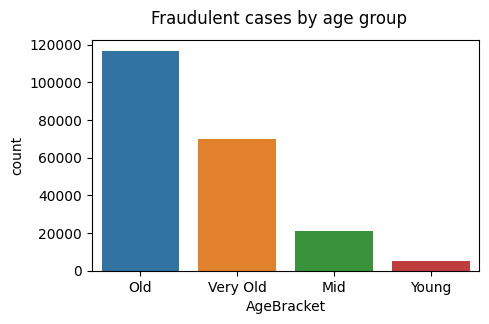

In [38]:
fig,ax=plt.subplots(figsize=(5,3))
fig.suptitle('Fraudulent cases by age group')
df=data.groupby('PotentialFraud')['AgeBracket'].value_counts().sort_values(ascending=False)['Yes'].reset_index()[:10]
sns.barplot(x='AgeBracket',y='count',data=df)
plt.show()

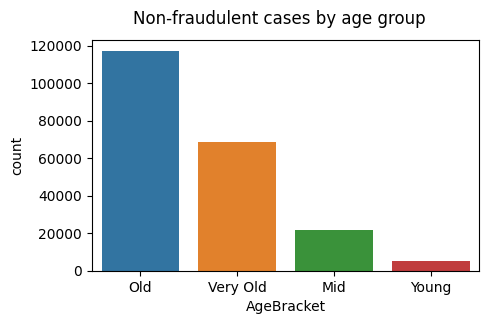

In [14]:
fig,ax=plt.subplots(figsize=(5,3))
fig.suptitle('Non-fraudulent cases by age group')
df=data.groupby('PotentialFraud')['AgeBracket'].value_counts().sort_values(ascending=False)['No'].reset_index()[:10]
sns.barplot(x='AgeBracket',y='count',data=df)
plt.show()

<Axes: xlabel='PotentialFraud', ylabel='ClaimDuration'>

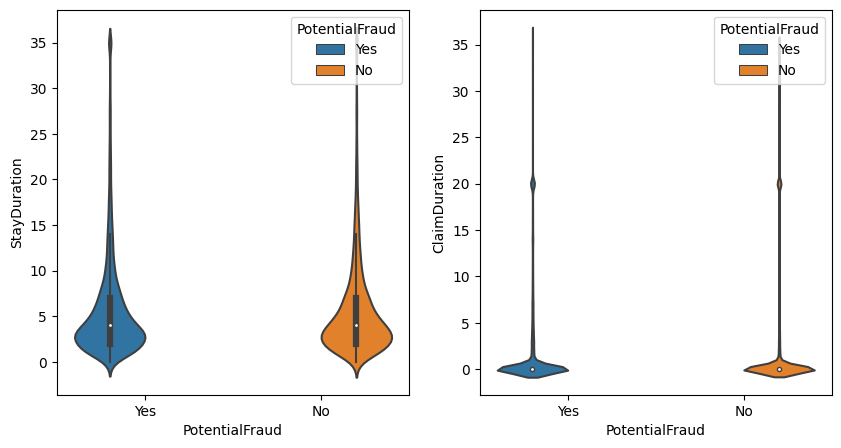

In [25]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
sns.violinplot(x='PotentialFraud',y='StayDuration',hue='PotentialFraud',data=data,ax=axs[0])
sns.violinplot(x='PotentialFraud',y='ClaimDuration',hue='PotentialFraud',data=data,ax=axs[1])

<Axes: xlabel='PotentialFraud', ylabel='AttPhyTotCl'>

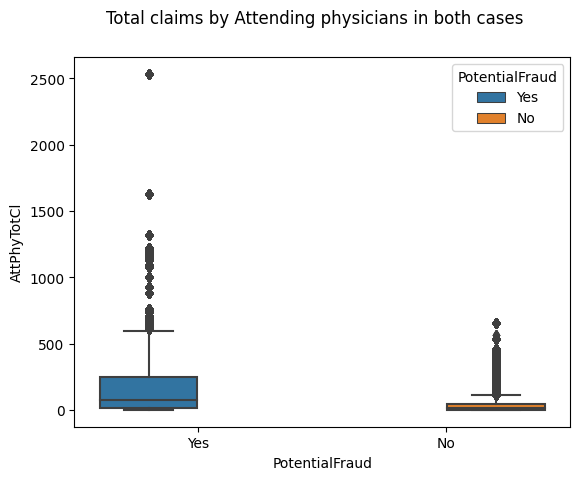

In [31]:
data['AttPhyTotCl'] = data.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
plt.suptitle('Total claims by Attending physicians in both cases')
sns.boxplot(x='PotentialFraud',y='AttPhyTotCl',hue='PotentialFraud',data=data)


<Axes: xlabel='PotentialFraud', ylabel='OpPhyTotCl'>

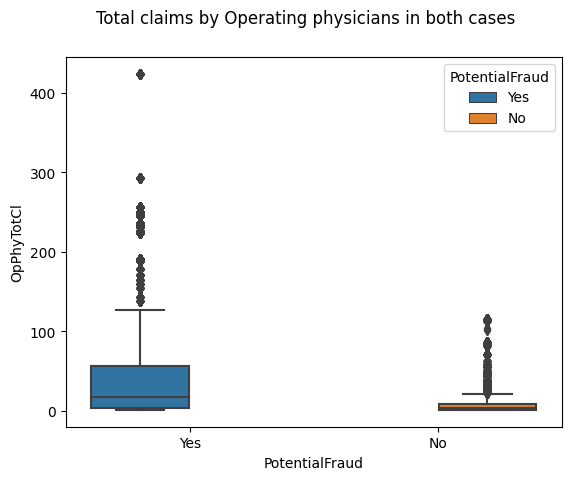

In [33]:
data['OpPhyTotCl'] = data.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
plt.suptitle('Total claims by Operating physicians in both cases')
sns.boxplot(x='PotentialFraud',y='OpPhyTotCl',hue='PotentialFraud',data=data)